# Introduction

In this exercise I will build a model to classify social media comments. The purpose is to train a NLP-classifier for sentiment analysis to detect whether those comments are hateful, racist or toxic insults. This will be done for 2 datasets and 2 different kind of models. 

We are working wit two datasets, which are very similar.

1. Detecting Insults in Social Commentary
2. Toxic Comment Classification Challenge

Both datasets come from Kaggle and contain social media comments. The difference for this datasets are the different target variables.

In the first dataset there is only one target variable, which detects whether a tweet or comment is an insult. This is a binary classification problem so the neural network will have one final neuron with a sigmoid activation function to predict the target variable.
 
The second dataset contains 6 different target variables, which are called "toxic", "severe_toxic", "obscene", "threat", "insult", "identity hate". So in this scenario a wider range of insults are adressed. It is important to mention that the occurences of those target variables are not mutually exclusive. However, the task of this assignment is to predict whether a comment hits a category. In this problem we will have a 6 unit sigmoid output layer, where each output unit determines whether the corresponding category is hit. 

The exercise will be split in the following sections, which will be repeated for either dataset  
1. Load pacoages and data: This step is the same for both datasets, although the packages are just loaded ones.
2. Data preprocessing: This section contains several functions, which clean the dataset and prepare it to be used in a meaningful way in the modelling step. 
3. Word embeddings and sentence indices: The word embeddings are loaded and the sentences are prepared so that they can be used as inputs for our RNN model.
4. Model for dataset 1: A RNN  model with GRU blocks
5. Model for dataset 2: Same model applied for the second dataset with some adjustments  

# 1. Load packages and data

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import time
import random
import matplotlib.pyplot as plt
import sklearn
from numpy import genfromtxt


#nltk.download('book')

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.book import *
#from gensim.models import Word2Vec
from string import punctuation
from nltk.tokenize import word_tokenize

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [2]:
train_data = pd.read_csv("train_data1.csv")
del train_data['Date']



share = sum(train_data['Insult'] == 0) / len(train_data['Insult'])

print("The share of non insult comments is", round(share,4) * 100, "%")
train_data[0:10]

The share of non insult comments is 73.42 %


,Insult,Comment
0,1,"""You fuck your dad."""
1,0,"""i really don't understand your point.\xa0 It ..."
2,0,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,"""listen if you dont wanna get married to a man..."
4,0,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."
5,0,"""@SDL OK, but I would hope they'd sign him to ..."
6,0,"""Yeah and where are you now?"""
7,1,"""shut the fuck up. you and the rest of your fa..."
8,1,"""Either you are fake or extremely stupid...may..."
9,1,"""That you are an idiot who understands neither..."


# 2. Data preprocessing

In this section several functions are defined to clean and preprocess the dataset for further use.

In order to be consistent with writing certain phrases we will implement the function $decontracted()$, which will convert phrases like "don't" to "do not" etc. 

In [3]:
def decontracted(phrase):
    
    """
    function that takes as input the most used english phrases and expands them to the actual
    words
    
    Input: 
    phrase - Phrases like "won't" or "don't"

    Returns: 
    The same phrase expanded to "will not" and "do not" respectively
    """
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"dont", "do not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r'\w*@\w*','', phrase)
    
    return phrase


In [4]:
phrase = decontracted("I don't like this movie, I won't watch it again")
print('The sentence is going to be:',phrase)

The sentence is going to be: I do not like this movie, I will not watch it again


The next function is used to make the data useable. This means that words are going to be split at stoping signs and all words are going to be written in lower case etc. Also the function $decontracted$ will be used in this function called $preproc$. At this point we are just preprocessing the data and are not investigating whether the sentences make sense, this will be adressed in the next section.

In [5]:
def preproc(data,word):


    sen = []

    for i in range(len(data)):
        sen.append(re.split(' |\\\\n|\\\\|\n\n|\n|xc2|xa0|x80|xe2|!|"|\.(?!\d)|\?(?!\d)|-|,',data[word][i]))

    for i in range(len(data)):  
        sen[i] = [word.lower() for word in sen[i]]
        sen[i] = [decontracted(word) for word in sen[i]]
    
    punct = list(punctuation)
    punct.append('``')
    punct.append("''")
    punct.append('--')
    punct.append('...')
    punct.append('')
    punct.append(',')
    punct.append("'")

    sentences = []
    
    for i in range(len(sen)):
        sentences.append([word for word in sen[i] if word not in punct])

        
    data = [' '.join(i) for i in sentences]
    data = np.asarray(data)    
    
    
    [data[i].split() for i in range(len(data))]
        
    return sen, sentences, data  


In [6]:
def word_length(data):

    length = []

    for i in range(len(data)):
        length.append(len(data[i].split()))
    
    max_len = max(length)
    return max_len

In [7]:
sen, sentences, data = preproc(train_data,'Comment')

[data[i].split() for i in range(len(data))][:5]

[['you', 'fuck', 'your', 'dad'],
 ['i',
  'really',
  'do',
  'not',
  'understand',
  'your',
  'point',
  'it',
  'seems',
  'that',
  'you',
  'are',
  'mixing',
  'apples',
  'and',
  'oranges'],
 ['a',
  'majority',
  'of',
  'canadians',
  'can',
  'and',
  'has',
  'been',
  'wrong',
  'before',
  'now',
  'and',
  'will',
  'be',
  'again',
  'unless',
  'you',
  'are',
  'supportive',
  'of',
  'the',
  'idea',
  'that',
  'nothing',
  'is',
  'full',
  'proof',
  'or',
  'perfect',
  'so',
  'you',
  'take',
  'your',
  'chances',
  'and',
  'if',
  'we',
  'should',
  'inadvertently',
  'kill',
  'your',
  'son',
  'or',
  'daughter',
  'then',
  'them',
  'is',
  'the',
  'breaks',
  'and',
  'we',
  'can',
  'always',
  'regard',
  'you',
  'as',
  'collateral',
  'damage',
  'like',
  'in',
  'wartime',
  'and',
  'sorry',
  'but',
  'the',
  'cheques',
  'in',
  'the',
  'mail'],
 ['listen',
  'if',
  'you',
  'do',
  'not',
  'wanna',
  'get',
  'married',
  'to',
  'a'

In [8]:
words = sentences[0]

for i in range(1,len(sentences)):
    words +=  sentences[i] 

print(FreqDist(words))
FreqDist(words).most_common(20)

<FreqDist with 16683 samples and 132655 outcomes>


[('the', 4814),
 ('you', 3729),
 ('to', 3248),
 ('a', 2971),
 ('and', 2824),
 ('of', 2240),
 ('i', 1813),
 ('is', 1705),
 ('that', 1598),
 ('are', 1565),
 ('in', 1544),
 ('it', 1355),
 ('your', 1281),
 ('for', 1073),
 ('on', 931),
 ('have', 890),
 ('not', 862),
 ('be', 764),
 ('they', 747),
 ('this', 738)]

# 3. Word Embeddings & sentence indices 

Here we are going to define the dictionary of the word embedding to be used as input for the model later and the positions of the words in the dictionary as input to the model.

In [9]:
def read_word_vectors(file_path):
    
    with open(file_path,'r') as vec:
        words = []
        words_to_vec = {}
        for line in vec:
            line = line.split()
            current_word = line[0]
            words.append(current_word)
            words_to_vec[current_word] = np.array(line[1:],dtype = 'float64')
        
        index_to_word = {}
        word_to_index = {}
    
        i = 1
    
        for word in sorted(words):
            index_to_word[i] = word
            word_to_index[word] = i
            i = i + 1

    return words_to_vec, word_to_index, index_to_word

In [10]:
file_path = 'glove.6B/glove.6B.100d.txt'

words_to_vec, word_to_index, index_to_word = read_word_vectors(file_path)

In [11]:
def sentence_to_index(data,word_to_index,max_len,temp):
    
    """
    function that takes a sentences and gives the vector of indices back for all the words in the sentence
    
    Input: 
    data ... That is the data set, which contains the sentences to be translated to indices 
    word_to_index ... The dictionary that holds the index of any word in the word embedding 
    max_len... Maximum length of a sentence. If a sentence does not have maximum length, then the additional fields 
                are filled with zeros 
    temp ... This function is used twice
                1. Identify how many sentences have words which are not in the Glove6B embedding. If there are too
                   many unidentifable words, then this sentences will be taken out of the data (temp == 0)
                2. For the actual indexing of the vectors to find out the word vector of certain words.
                
    Output:
    Index_vector ... A matrix which returns the index of every word of a sentence in the corresponding word embedding
    """

    m = data.shape[0] # number of traing examples
    index_vector = np.zeros((m,max_len),dtype = 'int32') # Matrix of all sentence examples and corresponding indices
    
    for i in range(m):
        # Standardize all words in the sentence to lower case and split them 
        sentence_words = data[i].lower().split()
        
        j = 0
        
        for word in sentence_words:
            if word in word_to_index.keys():
                index_vector[i,j] = word_to_index[word]
            elif temp == 0:
                index_vector[i,j] = -1
            else:
                index_vector[i,j] = 0
            j = j + 1
              
    return index_vector

If there are to many words in a comment which are not part of the dictionary these comments will be taken out of the dataset. The reason is that the model is learning on reliable and meaningful data.

In [12]:
def wordclean(vector,threshold):
    
    """
    
    
    """
    
    minus = []

    for i in range(len(vector)):
        minus.append(sum(vector[i] == -1))
    
    index = []

    for i in range(len(minus)):
        index.append(minus[i] < threshold)
  
    
    return index

In [13]:
max_len1 = word_length(data)

vector = sentence_to_index(data,word_to_index,max_len = max_len1,temp = 0)


print(data[2000].split())
vector[2000]

['funny', 'and', 'very', 'honest', 'part', 'of', 'me', 'thinks', 'ms', 'bell', 'is', 'very', 'gutsy', 'for', 'sharing', 'that', 'video', 'but', 'the', 'other', 'part', 'tells', 'me', 'that', 'losing', 'one', 'is', 'sh*t', 'over', 'a', 'petting', 'zoo', 'critter', 'is', 'just', 'a', 'little', 'this', 'side', 'of', 'weird']


array([155345,  54718, 377946, ...,      0,      0,      0], dtype=int32)

In [14]:
index = wordclean(vector, threshold = 10) 
data = data[index]

max_len2 = word_length(data)
print(max_len2)

733


# 4. Models 

In [15]:
def RNNprep(original_data,processed_data,index,n,word):

    """
    
    
    """
    
    target = original_data[word][index]
    target = np.asarray(target)
  

    a = np.zeros(len(processed_data))

    for i in range(0,len(processed_data)):
        a[i] = len(processed_data[i].split())

    print(sum(a<=n) / len(processed_data))    
    
    processed_data = processed_data[a <= n]
    target = target[a <=n]

#####################################


    df = pd.DataFrame({'Comment': processed_data, 'y':target})

    X = df['Comment']
    y = df['y']


    max_len2 = word_length(processed_data)

    
    return X,y,max_len2


In [16]:
X, y, max_len2 = RNNprep(train_data,data,index,70, 'Insult')
print('The maximum length of the sentences is going to be:',max_len2)

0.907312049434
The maximum length of the sentences is going to be: 70


## 4.2. RNN Model

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [3]:
from keras.models import Model,Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, LeakyReLU,GRU,Flatten,MaxPooling1D,Bidirectional,GlobalMaxPooling1D,Conv1D,Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import regularizers

Here we are adding the embedding layer that is going to use the first layer after the input layer to transform the index vector to their corresponding word vectors. 

In [19]:
def trained_embedding_layer(words_to_vec,word_to_index):
    
    """
    
    
    
    """
    
    vocab_len = len(word_to_index) + 1
    embedding_dim = words_to_vec['aha'].shape[0]
    
    emb_matrix = np.zeros((vocab_len,embedding_dim))
    
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = words_to_vec[word]
        
        
    embedding_layer = Embedding(input_dim = vocab_len, output_dim = embedding_dim, trainable = False)
    
    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

    

In [50]:
#input_shape = (max_len2,)

def RNN(input_shape, words_to_vec, word_to_index):
    """
    
    
    
    """

    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trained_embedding_layer(words_to_vec, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    X = Dropout(0.3)(embeddings)
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = GRU(units = 64, activation = 'tanh')(X)
    # Add dropout with a probability of 0.7
    X = Dropout(0.6)(X)

    # Problem with overfitting, so we are adding regularization and ease the architecture, playing around with 
    # different hyperparameter settings
    
    #X = LSTM(units = 128, activation = 'tanh')(X)
    # Add dropout with a probability of 0.7
    #X = Dropout(0.8)(X)
    # Propagate X through a Dense layer with sigmoid activation to get back a batch of 1-dim vectors.
    X = Dense(units = 1)(X)
    # Add a softmax activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)

    return model

Model specifications that are going to be used to optimize the model and find the best solution for the validation set

In [55]:
model = RNN((max_len2,), words_to_vec, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 70)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 70, 100)           40000100  
_________________________________________________________________
dropout_10 (Dropout)         (None, 70, 100)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total para

In [56]:
opt = Adam(lr=0.001,decay = 10e-3)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [57]:
X_train_index = sentence_to_index(np.asarray(X_train),word_to_index,max_len2,temp = 1)
Y_train_index = np.asarray(y_train)

In [58]:
checkpoint = ModelCheckpoint('model1_check.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
temp1 = model.fit(X_train_index, Y_train_index, validation_split = 0.1,epochs = 200, batch_size = 128, callbacks=[checkpoint])


Train on 2853 samples, validate on 318 samples
Epoch 1/200
2853/2853 [==============================] - 2s 841us/step - loss: 0.6657 - acc: 0.7182 - val_loss: 0.6189 - val_acc: 0.7327

Epoch 00001: val_acc improved from -inf to 0.73270, saving model to model1_check.h5
Epoch 2/200
2853/2853 [==============================] - 1s 435us/step - loss: 0.6082 - acc: 0.7199 - val_loss: 0.5848 - val_acc: 0.7327

Epoch 00002: val_acc did not improve from 0.73270
Epoch 3/200
2853/2853 [==============================] - 1s 434us/step - loss: 0.5970 - acc: 0.7203 - val_loss: 0.5808 - val_acc: 0.7327

Epoch 00003: val_acc did not improve from 0.73270
Epoch 4/200
2853/2853 [==============================] - 1s 432us/step - loss: 0.5927 - acc: 0.7199 - val_loss: 0.5805 - val_acc: 0.7327

Epoch 00004: val_acc did not improve from 0.73270
Epoch 5/200
2853/2853 [==============================] - 1s 437us/step - loss: 0.5942 - acc: 0.7199 - val_loss: 0.5821 - val_acc: 0.7327

Epoch 00005: val_acc did not 

2853/2853 [==============================] - 1s 452us/step - loss: 0.3378 - acc: 0.8580 - val_loss: 0.3778 - val_acc: 0.8302

Epoch 00085: val_acc did not improve from 0.83333
Epoch 86/200
2853/2853 [==============================] - 1s 450us/step - loss: 0.3451 - acc: 0.8517 - val_loss: 0.3854 - val_acc: 0.8019

Epoch 00086: val_acc did not improve from 0.83333
Epoch 87/200
2853/2853 [==============================] - 1s 446us/step - loss: 0.3384 - acc: 0.8524 - val_loss: 0.3799 - val_acc: 0.8176

Epoch 00087: val_acc did not improve from 0.83333
Epoch 88/200
2853/2853 [==============================] - 1s 456us/step - loss: 0.3437 - acc: 0.8598 - val_loss: 0.3819 - val_acc: 0.8113

Epoch 00088: val_acc did not improve from 0.83333
Epoch 89/200
2853/2853 [==============================] - 1s 446us/step - loss: 0.3446 - acc: 0.8535 - val_loss: 0.3821 - val_acc: 0.8050

Epoch 00089: val_acc did not improve from 0.83333
Epoch 90/200
2853/2853 [==============================] - 1s 451us/s

2853/2853 [==============================] - 1s 433us/step - loss: 0.3245 - acc: 0.8615 - val_loss: 0.3668 - val_acc: 0.8239

Epoch 00128: val_acc did not improve from 0.83648
Epoch 129/200
2853/2853 [==============================] - 1s 437us/step - loss: 0.3264 - acc: 0.8549 - val_loss: 0.3698 - val_acc: 0.8208

Epoch 00129: val_acc did not improve from 0.83648
Epoch 130/200
2853/2853 [==============================] - 1s 438us/step - loss: 0.3205 - acc: 0.8689 - val_loss: 0.3666 - val_acc: 0.8270

Epoch 00130: val_acc did not improve from 0.83648
Epoch 131/200
2853/2853 [==============================] - 1s 436us/step - loss: 0.3192 - acc: 0.8668 - val_loss: 0.3684 - val_acc: 0.8239

Epoch 00131: val_acc did not improve from 0.83648
Epoch 132/200
2853/2853 [==============================] - 1s 439us/step - loss: 0.3226 - acc: 0.8601 - val_loss: 0.3719 - val_acc: 0.8113

Epoch 00132: val_acc did not improve from 0.83648
Epoch 133/200
2853/2853 [==============================] - 1s 44

2853/2853 [==============================] - 1s 439us/step - loss: 0.3176 - acc: 0.8651 - val_loss: 0.3640 - val_acc: 0.8270

Epoch 00171: val_acc did not improve from 0.83962
Epoch 172/200
2853/2853 [==============================] - 1s 434us/step - loss: 0.3024 - acc: 0.8798 - val_loss: 0.3648 - val_acc: 0.8270

Epoch 00172: val_acc did not improve from 0.83962
Epoch 173/200
2853/2853 [==============================] - 1s 436us/step - loss: 0.3085 - acc: 0.8703 - val_loss: 0.3748 - val_acc: 0.8176

Epoch 00173: val_acc did not improve from 0.83962
Epoch 174/200
2853/2853 [==============================] - 1s 437us/step - loss: 0.2999 - acc: 0.8805 - val_loss: 0.3620 - val_acc: 0.8333

Epoch 00174: val_acc did not improve from 0.83962
Epoch 175/200
2853/2853 [==============================] - 1s 433us/step - loss: 0.3083 - acc: 0.8749 - val_loss: 0.3693 - val_acc: 0.8176

Epoch 00175: val_acc did not improve from 0.83962
Epoch 176/200
2853/2853 [==============================] - 1s 43

In [24]:
model = load_model('model1_check.h5')

## 4.3. Model evaluation

In [60]:
X_test_index = sentence_to_index(np.asarray(X_test), word_to_index, max_len = max_len2, temp = 1)
#Y_test_index = np.eye(2)[np.asarray(y_test).reshape(-1)]
Y_test_index = np.asarray(y_test)
loss, acc = model.evaluate(X_test_index, Y_test_index)
print()
print("Test accuracy = ",acc * 100, "%")


353/353 [==============================] - 0s 289us/step

Test accuracy =  85.552407932 %


Now we compare it with the benchmark model, where we use p = 1 - share as parameter for our bernouilli variable

In [62]:
y_random = np.random.binomial(size=len(y_test), n=1, p = 1-share)

In [63]:
# calculate the accuracy of the random benchmark model
error = np.zeros(len(y_test))

for i in range(0,len(y_test)):
    error[i] = abs(y_random[i] - np.asarray(y_test)[i])
    
acc_random = 1 - sum(error)/len(y_test)

print("The random accuracy is",acc_random*100,"%")

The random accuracy is 62.8895184136 %


Now we are going to predict and calculate the F1 score and predict comments we have not seen before. There we are going to use the sklearn function metrics.F1_score.

In [64]:
def predict(phrases):
    
    m = phrases.shape[0]
    
    y_pred = model.predict(sentence_to_index(phrases, word_to_index, max_len2, temp = 1))
    
    predict = np.zeros(m)
    
    for i in range(0,m):
        
        if y_pred[i] > 0.5:
            predict[i] = 1
        else:
            predict[i] = 0
        predict
        
    return predict
    


In [65]:
a = np.asarray(X_test)
y_predict = predict(a)

In [66]:
F1_model  = sklearn.metrics.f1_score(np.asarray(y_test),y_predict)
F1_random = sklearn.metrics.f1_score(np.asarray(y_test),y_random)

print("The F1_score of the model is:",F1_model)
print("The F1_score of the benchmark is:",F1_random)

The F1_score of the model is: 0.732984293194
The F1_score of the benchmark is: 0.306878306878


In [67]:
a = np.asarray(["I like you","Go to hell","You are a piece of shit", "Your mother is stupid"])
predict(a)

array([ 0.,  0.,  1.,  1.])

# 5. Dataset 2

## 5.1. Data preprocessing for dataset 2

Same procedure as for the first model. 

In [11]:
train_data2 = pd.read_csv("train.csv")
del train_data2['id']

rowSums = train_data2.sum(axis = 1)
binary = []

for i in range(0,len(train_data2)):
    if rowSums[i] > 0:
        binary.append(1)
    else:
        binary.append(0)

category_sum = np.zeros(6)
share2 = np.zeros(6)
for i in range(0,6):
    category_sum[i] = sum(train_data2.iloc[:,i+1])
    share2[i] = category_sum[i] / len(train_data2)
    print("The share of category on dataset",i,"is",round(share2[i]*100,4),"%")

The share of category on dataset 0 is 9.5844 %
The share of category on dataset 1 is 0.9996 %
The share of category on dataset 2 is 5.2948 %
The share of category on dataset 3 is 0.2996 %
The share of category on dataset 4 is 4.9364 %
The share of category on dataset 5 is 0.8805 %


In [13]:
train_data2['sum'] = rowSums
train_data2['binary'] = binary


share2 = sum(train_data2['binary'] == 0) / len(train_data2['binary'])

print("The share of non sensitive comments is", round(share2,4) * 100,"%")
train_data2[0:10]




The share of non sensitive comments is 89.83 %


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum,binary
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4,1
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0,0


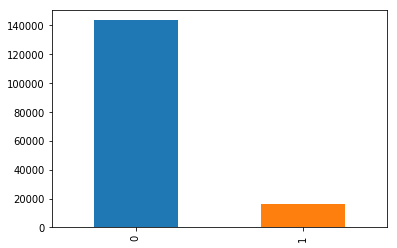

In [28]:
train_data2['binary'].value_counts().plot(kind='bar')


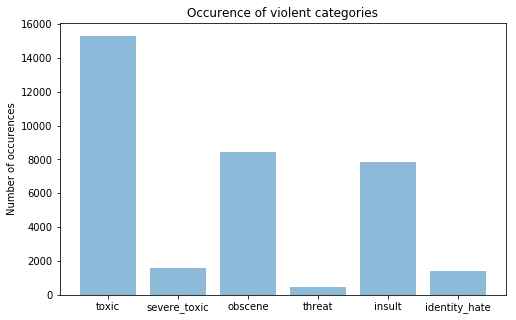

In [63]:
objects = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')
y_pos = np.arange(6)
performance = category_sum
 
    
plt.figure(figsize=(8,5))          
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of occurences')
plt.title('Occurence of violent categories')
 

plt.show()

Same functions as for the first model for the data preprocessing and preparation to be used for the model

In [22]:
sen2, sentences2, data2 = preproc(train_data2,'comment_text')

In [23]:
max_len3 = word_length(data2)
vector2 = sentence_to_index(data2,word_to_index,max_len = max_len3,temp = 0)

In [24]:
index2 = wordclean(vector2, threshold = 10) 
data2 = data2[index2]

max_len4 = word_length(data2)
print(max_len4)

1403


In [25]:
def RNNprep2(original_data,processed_data,index,n,word):

    """
    
    
    """
    
    target = original_data[index]
   # target = np.asarray(target)
  

    a = np.zeros(len(processed_data))

    for i in range(0,len(processed_data)):
        a[i] = len(processed_data[i].split())

    print(sum(a<=n) / len(processed_data))    
    
    processed_data = processed_data[a <= n]
    target = target[a<=n]

#####################################


    df = pd.DataFrame({'Comment': processed_data})

    X = df['Comment']
    y = target


    max_len2 = word_length(processed_data)

    
    return X,y,max_len2


In [26]:
X2, y2, max_len4 = RNNprep2(train_data2,data2,index2,120,'binary')
print('The maximal length of the sentences is',max_len4,'words')

0.903206872632
The maximal length of the sentences is 120 words


In [27]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=2)

In [28]:
del y_train2['comment_text']
del y_train2['binary']
del y_train2['sum']
y_train2

,toxic,severe_toxic,obscene,threat,insult,identity_hate
34780,0,0,0,0,0,0
120029,0,0,0,0,0,0
65357,0,0,0,0,0,0
105556,0,0,0,0,0,0
23282,0,0,0,0,0,0
75159,0,0,0,0,0,0
71894,1,0,1,0,1,0
34570,0,0,0,0,0,0
135488,0,0,0,0,0,0
159480,0,0,0,0,0,0


## 5.2. Model

In [29]:
def RNN2(input_shape, words_to_vec, word_to_index):
    
    """
    
    
    
    """

    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trained_embedding_layer(words_to_vec, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
   

    # When there is just one LSTM layer you don't need the batch of sequences since it is only forwarded to the 
    # dense unit 

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state

    X = GRU(units = 64, activation = 'tanh')(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.6)(X)
    # Propagate X through a Dense layer with sigmoid activation to get back a batch of 1-dim vectors.
    
    X = Dense(units = 6)(X)
    # X = Dense(units = 64)(X)
    # Add a softmax activation
    X = Activation('sigmoid')(X)
    # X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)

    return model

In [30]:
def RNN2_improved(input_shape, words_to_vec, word_to_index):
    
    """
    
    
    
    """

    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trained_embedding_layer(words_to_vec, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    
    embeddings = embedding_layer(sentence_indices)
    X = Dropout(0.25)(embeddings)

    X = Bidirectional(GRU(units = 64, activation = 'tanh',return_sequences = True))(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with sigmoid activation to get back a batch of 1-dim vectors.
    
    X = X = GlobalMaxPooling1D()(X)
    X = Dense(units = 6)(X)
    # Add a softmax activation
    X = Activation('sigmoid')(X)
    
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)

    return model

In [80]:
model2 = RNN2((max_len4,), words_to_vec, word_to_index)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 120, 100)          40000100  
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
_________________________________________________________________
activation_7 (Activation)    (None, 6)                 0         
Total params: 40,032,170
Trainable params: 32,070
Non-trainable params: 40,000,100
___________________________________________________________

In [119]:
opt = Adam(lr=0.005, decay=1e-8)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [34]:
X_train_index2 = sentence_to_index(np.asarray(X_train2),word_to_index,max_len4,temp = 1)
Y_train_index2 = np.asarray(y_train2)

In [95]:
checkpoint2 = ModelCheckpoint('model2.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
temp2 = model2.fit(X_train_index2, Y_train_index2,validation_split = 0.1,epochs = 10, batch_size = 512, callbacks=[checkpoint2])
#validation_data = (X_val_index3,Y_val_index3)

Train on 97498 samples, validate on 10834 samples
Epoch 1/10
97498/97498 [==============================] - 48s 488us/step - loss: 0.1324 - acc: 0.9675 - val_loss: 0.0603 - val_acc: 0.9787

Epoch 00001: val_acc improved from -inf to 0.97866, saving model to model2.h5
Epoch 2/10
97498/97498 [==============================] - 47s 478us/step - loss: 0.0622 - acc: 0.9785 - val_loss: 0.0582 - val_acc: 0.9787

Epoch 00002: val_acc improved from 0.97866 to 0.97868, saving model to model2.h5
Epoch 3/10
97498/97498 [==============================] - 47s 477us/step - loss: 0.0559 - acc: 0.9802 - val_loss: 0.0547 - val_acc: 0.9802

Epoch 00003: val_acc improved from 0.97868 to 0.98025, saving model to model2.h5
Epoch 4/10
97498/97498 [==============================] - 47s 478us/step - loss: 0.0526 - acc: 0.9812 - val_loss: 0.0545 - val_acc: 0.9799

Epoch 00004: val_acc did not improve from 0.98025
Epoch 5/10
97498/97498 [==============================] - 47s 478us/step - loss: 0.0511 - acc: 0.981

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


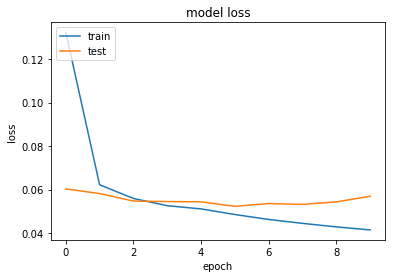

In [100]:
print(temp2.history.keys())
plt.plot(temp2.history['loss'])
plt.plot(temp2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


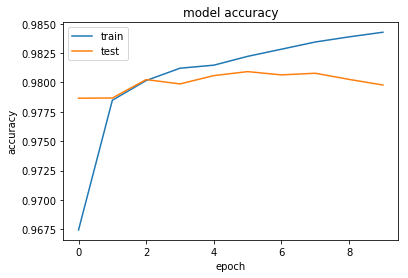

In [101]:
print(temp2.history.keys())
plt.plot(temp2.history['acc'])
plt.plot(temp2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
model2_improved = RNN2_improved((max_len4,), words_to_vec, word_to_index)
model2_improved.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 120, 100)          40000100  
_________________________________________________________________
dropout_7 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 120, 128)          63360     
_________________________________________________________________
dropout_8 (Dropout)          (None, 120, 128)          0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
__________

In [42]:
opt = Adam(lr=0.005, decay=1e-8)
model2_improved.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [43]:
checkpoint2_improved = ModelCheckpoint('model2_improved.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
temp2_improved = model2_improved.fit(X_train_index2, Y_train_index2,validation_split = 0.1,epochs = 10, batch_size = 512, callbacks=[checkpoint2_improved])


Train on 97498 samples, validate on 10834 samples
Epoch 1/10
97498/97498 [==============================] - 113s 1ms/step - loss: 0.0877 - acc: 0.9707 - val_loss: 0.0912 - val_acc: 0.9793

Epoch 00001: val_acc improved from -inf to 0.97931, saving model to model2_improved.h5
Epoch 2/10
97498/97498 [==============================] - 111s 1ms/step - loss: 0.0578 - acc: 0.9793 - val_loss: 0.0763 - val_acc: 0.9805

Epoch 00002: val_acc improved from 0.97931 to 0.98049, saving model to model2_improved.h5
Epoch 3/10
97498/97498 [==============================] - 111s 1ms/step - loss: 0.0540 - acc: 0.9801 - val_loss: 0.0707 - val_acc: 0.9803

Epoch 00003: val_acc did not improve from 0.98049
Epoch 4/10
97498/97498 [==============================] - 111s 1ms/step - loss: 0.0515 - acc: 0.9810 - val_loss: 0.0712 - val_acc: 0.9812

Epoch 00004: val_acc improved from 0.98049 to 0.98115, saving model to model2_improved.h5
Epoch 5/10
97498/97498 [==============================] - 111s 1ms/step - los

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


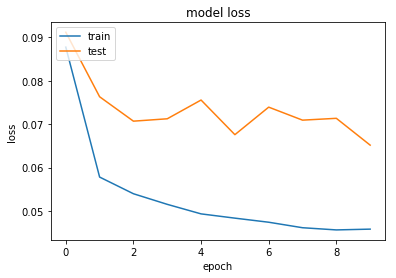

In [44]:
print(temp2_improved.history.keys())
plt.plot(temp2_improved.history['loss'])
plt.plot(temp2_improved.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


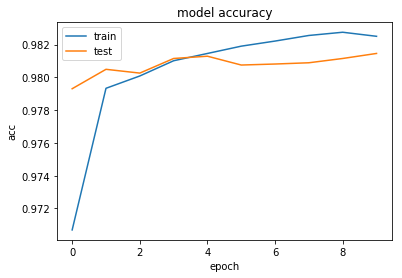

In [45]:
print(temp2_improved.history.keys())
plt.plot(temp2_improved.history['acc'])
plt.plot(temp2_improved.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 5.3. Model evaluation

In [46]:
model2_imp = load_model("model2_improved.h5")

In [47]:
del y_test2['comment_text']
del y_test2['sum']
del y_test2['binary']

In [48]:
X_test_index2 = sentence_to_index(np.asarray(X_test2), word_to_index, max_len = max_len4, temp = 1)
Y_test_index2 = np.asarray(y_test2)
loss2, acc2 = model2_imp.evaluate(X_test_index2, Y_test_index2)
print()
print("Test accuracy = ",acc2 * 100, "%")

27084/27084 [==============================] - 16s 587us/step

Test accuracy =  98.1471212131 %


In [49]:
def predict2(phrases):
    
    m = phrases.shape[0]
    
    y_pred2 = model2_imp.predict(sentence_to_index(phrases, word_to_index, max_len4, temp = 1))
    
    predict = np.zeros((m,6))
    
    for i in range(0,m):
        for j in range(0,6):

            if y_pred2[i,j] > 0.5:
                predict[i,j] = 1
            else:
                predict[i,j] = 0
    predict
        
    return predict
    


In [53]:
examples = np.asarray(("You are an asshole","You are dead",
                       "I do not really care about this","I like this movie","I will kill them all"))

In [54]:
model2_imp.predict(sentence_to_index(examples, word_to_index, max_len4, temp = 1))

array([[ 0.93313777,  0.3603996 ,  0.87037194,  0.04358162,  0.8532306 ,
         0.11601751],
       [ 0.76458448,  0.18274066,  0.27549881,  0.17343172,  0.52819169,
         0.08317558],
       [ 0.0784456 ,  0.01596765,  0.03552206,  0.01396521,  0.02803898,
         0.00919752],
       [ 0.06210713,  0.01732511,  0.0315634 ,  0.01205957,  0.01927907,
         0.00815657],
       [ 0.63853103,  0.12435254,  0.17950298,  0.59333283,  0.21743433,
         0.05745389]], dtype=float32)

In [55]:
predictions2 = predict2(examples)
predictions2

array([[ 1.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  0.]])

In [58]:
y_random2 = np.zeros((len(y_test2),6))

In [64]:
for i in range(0,len(y_test2)):
    for j in range(0,6):
        
        y_random2[i,j] = np.random.binomial(n=1, p = share2[j])
        
        

In [65]:
# calculate the accuracy of the random benchmark model
temp = np.zeros(len(y_test2))
error2 = np.zeros(len(y_test2))

for i in range(0,len(y_test2)):
    temp = np.sum(abs(y_random2 - np.asarray(y_test2)),axis = 1)
    if temp[i] > 0:
        error2[i] = 1
    else:
        error2[i] = 0
        
acc_random2 = 1 - sum(error2)/len(y_test2)

print("The random accuracy is",acc_random2*100,"%")

The random accuracy is 71.1859400384 %


In [66]:
a2 = np.asarray(X_test2)
y_predict2 = predict2(a2)

In [67]:
F1_model2  = sklearn.metrics.f1_score(np.asarray(y_test2),y_predict2,average='macro')
F1_random2 = sklearn.metrics.f1_score(np.asarray(y_test2),y_random2,average='macro')

print("The F1_score of the model is:",F1_model2)
print("The F1_score of the benchmark is:",F1_random2)

The F1_score of the model is: 0.576397909942
The F1_score of the benchmark is: 0.0371604964048
